In [1]:
import geopandas as gpd
import fiona
import osmnx as ox
import folium
from fiona.model import to_dict
from shapely.geometry import shape
from branca.colormap import LinearColormap
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import random
from shapely.geometry import Polygon, Point

from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

In [2]:
def Leuven_map():
    point = (50.849738563227824, 4.644786576420597)
    m = folium.Map(location=point, zoom_start = 12)
    return m

In [3]:
m = Leuven_map()

## CYCLIC GRAPH

In [5]:
cyclic = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/cycling_data/cycling_network.gpkg')
cyclic = cyclic.to_crs(epsg=4326)

In [6]:
nan_length = list(np.where(cyclic['LENGTE'].isna())[0])
cyclic.drop(nan_length, axis = 0, inplace = True)
cyclic.reset_index(inplace = True)

In [23]:
cyclic['id'] = list(range(len(cyclic)))

start = []
end = []
geom = []

for i in cyclic['id']:  
    start.append(cyclic['geometry'][i].coords[0])
    end.append(cyclic['geometry'][i].coords[-1])
    
cyclic['start'] = start
cyclic['end'] = end
#dict key:coordinate - value:id
nodes = list(set(start).union(set(end)))
nodes.sort()
for point in nodes:
    geom.append(Point(point))

nodes_dict = {}
id_nodes = {}
for node in nodes:
    nodes_dict['id'] = nodes_dict.get('id', []) + [nodes.index(node)]
    nodes_dict['x']= nodes_dict.get('x', []) + [node[0]]
    nodes_dict['y']= nodes_dict.get('y', []) + [node[1]]

    id_nodes[(node[0], node[1])] = nodes.index(node)

    
cyclic_nodes = gpd.GeoDataFrame(nodes_dict, crs='epsg:4326', geometry= geom )

In [24]:
edges = {}

for i in cyclic['id']:
    edges['u'] = edges.get('u', []) + [id_nodes[cyclic['start'][i]]]
    edges['v'] = edges.get('v', []) + [id_nodes[cyclic['end'][i]]]
    edges['geometry'] = edges.get('geometry', []) + [cyclic['geometry'][i]]
    edges['length'] = edges.get('length', []) + [cyclic['LENGTE'][i]]
    edges['key'] = edges.get('key', []) + [i]

cyclic_edges = gpd.GeoDataFrame(edges, crs='epsg:4326')

In [25]:
cyclic_edges = cyclic_edges.set_index(['u', 'v', 'key'])

In [26]:
Gc = ox.graph_from_gdfs(cyclic_nodes, cyclic_edges)

In [7]:
tess_squared = tiler.get('squared', base_shape='Leuven, Belgium', meters=1000)

In [4]:
def get_convex_hull(tess):
    polygon = tess.at[0, 'geometry']
    for tile in tess['geometry']:
        polygon = polygon.union(tile)
    return polygon.convex_hull

poly_ch = get_convex_hull(tess_squared)

NameError: name 'tess_squared' is not defined

In [37]:
hubs = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/hub_data_leuven/mobility_hubs.gpkg', crs={'init':'epsg:31370'})
hubs = hubs.to_crs(epsg=4326)

### ISOCHRONE

In [29]:
place = 'Leuven, Belgium'
network_type = 'bike'
threshold = 15
travel_speed = 8.5 #walking speed in km/hour

In [28]:
G = nx.to_undirected(Gc)

In [30]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
lon, lat = (4.70053, 50.87984)

In [32]:
center_node = ox.nearest_nodes(G, X=lon, Y = lat)
G.nodes[center_node]

{'id': 2674, 'x': 4.70053984670537, 'y': 50.8798258193953}

In [20]:
#center_node = 3403
#G.nodes[center_node]
#highest betweenness centrality

{'id': 3403, 'x': 4.714300199215316, 'y': 50.88456957667612}

In [ ]:
#clos_centr = nx.betweenness_centrality(G)
#df = pd.DataFrame.from_dict({
#    'node': list(clos_centr.keys()),
#    'centrality': list(clos_centr.values())
#})
#df = df.sort_values('centrality', ascending=False)

#df

In [33]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

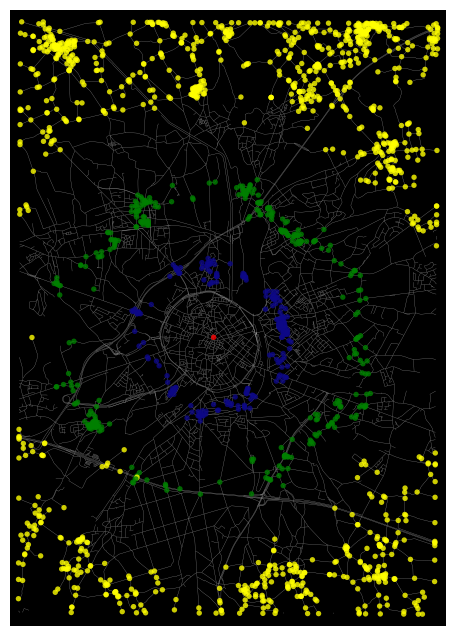

In [34]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_found = []

subgraph = nx.ego_graph(G, center_node, radius=30000, distance = 'time')
for node in subgraph.nodes():
    w = nx.shortest_path_length(subgraph, center_node, node, weight= 'time')
    if 13.5 <= w <= 15.5:
        node_found.append(node)
        node_colors[node] = '#0d0887'
    if 27.5 <= w <= 30.5:
        node_colors[node] = 'green'
    if 45.5 <= w:
        node_colors[node] = 'yellow'
    if node == center_node:
        node_colors[node] = 'red'
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')



In [59]:
m = Leuven_map()

In [45]:
G.nodes()[0]

{'id': 0, 'x': 4.63299100586654, 'y': 50.820110452498106}

In [62]:
for node in node_found:
    punto = (G.nodes[node]['x'], G.nodes[node]['y'])
    indice = np.argmin(hubs['geometry'].hausdorff_distance(Point(punto)))
    coord = list(hubs['geometry'][indice].coords)[0]
    folium.Marker(location = (coord[1], coord[0])).add_to(m)
    folium.Marker(location = (punto[1], punto[0]), icon=folium.Icon(color='black',icon_color='#FFFF00'))

C:\Users\and99\AppData\Local\Temp\ipykernel_20200\942574196.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'hausdorff_distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  indice = np.argmin(hubs['geometry'].hausdorff_distance(Point(punto)))


## BUS STOPS IN LEUVEN

In [9]:
stops = pd.read_csv('stops.csv')

In [6]:
zones = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/od_data_leuven/OD_zones_leuven.gpkg')
zones = zones.to_crs('EPSG:4326')
zones_leuven = zones[zones['VREGIO_L'] == 'LEUVEN']

In [ ]:
zones_leuven = zones_leuven[zones_leuven['geometry'].intersects(poly_ch)]
folium.GeoJson(zones_leuven).add_to(m)

In [14]:
coords = []
for index, rows in stops.iterrows():
    coords.append(Point(rows['stop_lon'], rows['stop_lat']))

coords = gpd.GeoSeries(coords, crs = 'EPSG:4326')

In [20]:
stops = coords[coords.within(poly_ch)]
folium.GeoJson(stops).add_to(m)

## INCIDENTI